# Backpropagation Part 1

The objective of this notebook is to compute gradients without the help of TensorFlow or PyTorch autograd. I will derive the gradients of 

- Affine transformation, a.k.a. Dense layer in TensorFlow Keras
- ReLU Activation
- Sigmoid Activation
- Mean Squared Error

## Demonstrate with TensorFlow

Let's start with how TensorFlow computes gradient with backpropagation. Here is a simple architecture with `input_shape=(3,3)` and `batch_size=1`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.losses import MeanSquaredError

2023-03-27 20:44:22.740357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 20:44:22.865325: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 20:44:23.444058: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-27 20:44:23.444146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
tf_model = Sequential([
    Dense(6, activation="relu", name="dense_1", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
    Dense(3, activation="relu", name="dense_2", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
    Dense(1, activation="sigmoid", name="dense_3", kernel_initializer=RandomNormal(stddev=0.01), bias_initializer=Zeros()),
])
tf_model.build((None, 1))
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6)                 12        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


2023-03-27 20:44:24.270934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 20:44:24.276865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-27 20:44:24.276892: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-27 20:44:24.277357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

To keep things simple, I want my model to learn `sine` function. I define a L2 loss function. Since my model uses activation layers, the outputs should match that of `sine`.

$$
\text{sin}(x) = \text{model}(x) = \hat{y} \in [0, 1]
$$

Input:
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1]
Output: 
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Loss:
 0.116013035


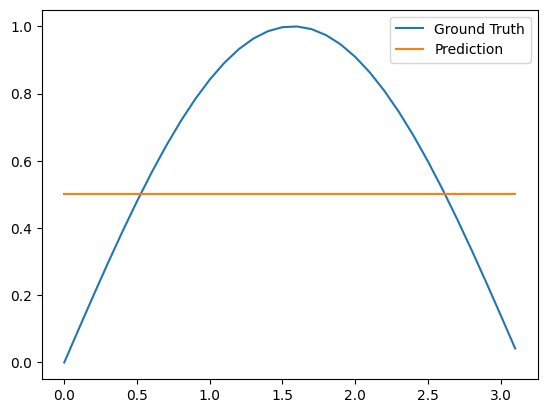

In [3]:
x = np.arange(0., 3.2, 0.1)
y_true = np.sin(x)

x = np.expand_dims(x, axis=-1)
y_true = np.expand_dims(y_true, axis=-1)

y_pred = tf_model(x).numpy()
mse = MeanSquaredError()
loss = mse(y_true, y_pred).numpy()

print("Input:\n", x.flatten())
print("Output: \n", np.round(y_pred, decimals=2).flatten())
print("Loss:\n", loss)
plt.plot(x.flatten(), y_true.flatten(), label="Ground Truth")
plt.plot(x.flatten(), y_pred.flatten(), label="Prediction")
plt.legend()

Compute gradients using TensorFlow.

In [4]:
with tf.GradientTape() as tape:
    y_pred = tf_model(x)
    loss = mse(y_true, y_pred)
    
gradients = tape.gradient(loss, tf_model.trainable_variables)
for var, grad in zip(tf_model.trainable_variables, gradients):
    print("Variable:", var.name)
    print("Gradient:\n", grad.numpy(), "\n")

Variable: dense_1/kernel:0
Gradient:
 [[-2.4163039e-06  3.4067969e-07  2.6594885e-06  0.0000000e+00
   3.4254313e-06  4.0333862e-06]] 

Variable: dense_1/bias:0
Gradient:
 [-1.6388769e-06  2.3106867e-07  1.8038187e-06  0.0000000e+00
  2.3233249e-06  2.7356755e-06] 

Variable: dense_2/kernel:0
Gradient:
 [[4.9851053e-07 0.0000000e+00 1.8573847e-07]
 [2.2979732e-06 0.0000000e+00 8.5619433e-07]
 [3.2535436e-06 0.0000000e+00 1.2122276e-06]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [6.0896434e-07 0.0000000e+00 2.2689213e-07]
 [1.8945034e-06 0.0000000e+00 7.0586702e-07]] 

Variable: dense_2/bias:0
Gradient:
 [2.2116188e-04 0.0000000e+00 8.2402003e-05] 

Variable: dense_3/kernel:0
Gradient:
 [[-1.4289822e-05]
 [ 0.0000000e+00]
 [-8.5941047e-06]] 

Variable: dense_3/bias:0
Gradient:
 [-0.06242947] 



## Demonstrate with Numpy

Without the help of auto differentiation, now I need to write the same functionality with numpy and some calculus. For weight initialization, keep in mind that
`numpy` returns random normal distribution with `mean=0` and `std=1`. A new random normal distribution can be defined as follows.

$$
X^\prime = \sigma X + \mu
$$

In [5]:
class NumpyModel:
    """Model V1 will only perform forward propagation.
    """
    def __init__(self, weight_stddev=0.01):
        self.params = {
            "dense_1/kernel": weight_stddev * np.random.randn(1, 6),
            "dense_1/bias": np.zeros((6,)),
            "dense_2/kernel": weight_stddev * np.random.randn(6, 3),
            "dense_2/bias": np.zeros((3,)),
            "dense_3/kernel": weight_stddev * np.random.randn(3, 1),
            "dense_3/bias": np.zeros((1,)),
        }
        
        self.activations = {
            "dense_1/act": self._relu,
            "dense_2/act": self._relu,
            "dense_3/act": self._sigmoid
        }

        self.forward_cache = {}
        
    def __call__(self, x):
        self.forward_cache = {
            "input": x
        } 
        
        x = np.matmul(x, self.params['dense_1/kernel']) + self.params['dense_1/bias']
        self.forward_cache["affine_1"] = x
        x = self.activations['dense_1/act'](x)
        self.forward_cache["affine_1_act"] = x
        
        x = np.matmul(x, self.params['dense_2/kernel']) + self.params['dense_2/bias']
        self.forward_cache["affine_2"] = x
        x = self.activations['dense_2/act'](x)
        self.forward_cache["affine_2_act"] = x
        
        x = np.matmul(x, self.params['dense_3/kernel']) + self.params['dense_3/bias']
        self.forward_cache["affine_3"] = x
        x = self.activations['dense_3/act'](x)
        self.forward_cache["affine_3_act"] = x
        
        return x
    
    def _relu(self, x):
        return np.maximum(x, 0)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-1 * x))
    
    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

Now I have a model that produces the output and loss value like the TensorFlow model I setup above.

In [6]:
np_model = NumpyModel()

y_pred = np_model(x)
loss = np_model.mean_squared_error(y_true, y_pred)

print("Input:\n", x.flatten())
print("Output: \n", y_pred.flatten())
print("Loss:\n", loss.flatten())

Input:
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1]
Output: 
 [0.5        0.5000001  0.50000021 0.50000031 0.50000041 0.50000051
 0.50000062 0.50000072 0.50000082 0.50000092 0.50000103 0.50000113
 0.50000123 0.50000133 0.50000144 0.50000154 0.50000164 0.50000174
 0.50000185 0.50000195 0.50000205 0.50000215 0.50000226 0.50000236
 0.50000246 0.50000256 0.50000267 0.50000277 0.50000287 0.50000297
 0.50000308 0.50000318]
Loss:
 [0.11601256]


## Computing Gradient Analytically

### Gradient of Loss

The L2 loss is defined as follows.

$$
L = \frac{1}{N}\Sigma_{i=0}^{N-1} (y_{i} - \hat{y}_{i})^2
$$

The derivative of loss with respect to prediction is then:

$$
\frac{\partial L}{\partial \hat{y}} = \frac{2}{N} \cdot (y - \hat{y})
$$

In [7]:
grad_y_pred = 2 * (y_pred - y_true) / np.prod(y_pred.shape)
grad_y_pred.flatten()

array([ 0.03125   ,  0.02501042,  0.01883318,  0.01278001,  0.00691138,
        0.00128594, -0.00404012, -0.00901356, -0.0135847 , -0.01770787,
       -0.02134187, -0.02445039, -0.02700237, -0.0289723 , -0.03034052,
       -0.03109334, -0.03122325, -0.03072894, -0.02961536, -0.02789363,
       -0.02558096, -0.02270045, -0.01928088, -0.01535643, -0.01096629,
       -0.00615435, -0.00096867,  0.00453893,  0.01031342,  0.0162971 ,
        0.02243019,  0.02865141])

### Gradient of Sigmoid

The activation of last layer is a sigmoid function.

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

The input `x` is the output from `dense_3` layer. Let's call it $A_3$, given that it's the output of an affine transformation. Then the derivative of sigmoid function or `y_pred` with respect to $A_3$ is:

$$
\frac{\partial \sigma}{\partial A_3} = (1 - \sigma(A_3)) * \sigma(A_3) =  \frac{\partial \hat{y}}{\partial A_3} = (1 - \hat{y}) * \hat{y}
$$

I want the gradient of loss with respect to $A_3$. I need to apply **chain rule** here.

$$
\frac{\partial L}{\partial A_3} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial A_3}
$$

In [8]:
grad_affine_3 = grad_y_pred * (1 - y_pred) * y_pred
print("Affine 3 gradient shape", grad_affine_3.shape)

Affine 3 gradient shape (32, 1)


### Gradient of Trainable Variables

So far none of the gradients I have computed should be applied to any variable because the loss and activation functions above do not contain any parameters. However, I can use chain rules to **backpropagate** gradients to my trainable variables.

The first trainable variables, counting from the output, are `dense_3_kernel` and `dense_3_bias`. These two variables along with input from previous layer produces the affine output.

$$
A_3 = xW_3 + b_3 = \text{ReLU}(A_2)W_3 + b_3
$$

The gradient of affine with respect to kernel and bias are:

$$
\frac{\partial A_3}{\partial W_3} = x
$$

$$
\frac{\partial A_3}{\partial b_3} = 1
$$

But I am more interested in the gradient of loss with respect to kernel and bias. So I apply chain rule:

$$
\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial W_3} 
$$

$$
\frac{\partial L}{\partial b_3} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial b_3} 
$$

In [9]:
print("Dense 3 kernel shape", np_model.params['dense_3/kernel'].shape)
grad_dense_3_kernel = np.matmul(np_model.forward_cache["affine_2_act"].T, grad_affine_3)
print("Dense 3 kernel gradient shape", grad_dense_3_kernel.shape)

Dense 3 kernel shape (3, 1)
Dense 3 kernel gradient shape (3, 1)


In [10]:
print("Dense 3 bias shape", np_model.params['dense_3/bias'].shape)
grad_dense_3_bias = np.sum(grad_affine_3.T * 1, axis=1)
print("Dense 3 bias gradient shape", grad_dense_3_bias.shape)

Dense 3 bias shape (1,)
Dense 3 bias gradient shape (1,)


### Gradients of ReLU Activation

Repeat the same process for `dense_2` layer. However, I have `ReLU` activation and its gradient is slightly different from sigmoid activation.

$$
\frac{\partial \text{ReLU}}{\partial x} = \frac{\partial \text{ReLU}}{\partial A_2} = \begin{cases}
1 & \text{ if } x \gt 0 \\ 
0 & \text{ else }  
\end{cases}
$$

What I need is

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial A_3}\frac{\partial A_3}{\partial \;\text{ReLU}} \frac{\partial \text{ReLU}}{\partial A_2}
$$

In [11]:
print("Affine 2 shape", np_model.forward_cache["affine_2"].shape)

grad_affine_2_act = np.matmul(grad_affine_3, np_model.params['dense_3/kernel'].T)
grad_affine_2 = grad_affine_2_act.copy()
grad_affine_2[np_model.forward_cache["affine_2"] < 0] = 0 # ReLU Backprop
print("Affine 2 gradient shape", grad_affine_2.shape)

Affine 2 shape (32, 3)
Affine 2 gradient shape (32, 3)


Then I can compute the gradients of layer 2 kernel weights and bias.

$$
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_2} \frac{\partial A_2}{\partial W_2}
$$


In [12]:
print("Dense 2 kernel shape", np_model.params['dense_2/kernel'].shape)
grad_dense_2_kernel = np.matmul(np_model.forward_cache["affine_1_act"].T, grad_affine_2)
print("Dense 2 kernel gradient shape", grad_dense_2_kernel.shape)

Dense 2 kernel shape (6, 3)
Dense 2 kernel gradient shape (6, 3)


In [13]:
print("Dense 2 bias shape", np_model.params['dense_2/bias'].shape)
grad_dense_2_bias = np.sum(grad_affine_2.T * 1, axis=1)
print("Dense 2 bias gradient shape", grad_dense_2_bias.shape)

Dense 2 bias shape (3,)
Dense 2 bias gradient shape (3,)


Finally, repeat the same process for `dense_1` layer.

In [14]:
print("Affine 1 shape", np_model.forward_cache["affine_1"].shape)
grad_affine_1_act = np.matmul(grad_affine_2, np_model.params['dense_2/kernel'].T)

grad_affine_1 = grad_affine_1_act.copy()
grad_affine_1[np_model.forward_cache["affine_1"] < 0] = 0
print("Affine 1 gradient shape", grad_affine_1.shape)

Affine 1 shape (32, 6)
Affine 1 gradient shape (32, 6)


In [15]:
print("Dense 1 kernel shape", np_model.params['dense_1/kernel'].shape)
grad_dense_1_kernel = np.matmul(np_model.forward_cache["input"].T, grad_affine_1)
print("Dense 1 kernel gradient shape", grad_dense_1_kernel.shape)

Dense 1 kernel shape (1, 6)
Dense 1 kernel gradient shape (1, 6)


In [16]:
print("Dense 1 bias shape", np_model.params['dense_1/bias'].shape)
grad_dense_1_bias = np.sum(grad_affine_1 * 1, axis=0)
print("Dense 1 bias gradient shape", grad_dense_1_bias.shape)

Dense 1 bias shape (6,)
Dense 1 bias gradient shape (6,)


Look at the values of all the gradients computed.

In [17]:
print("Dense 3 kernel gradients\n", grad_dense_3_kernel)
print("Dense 3 bias gradients\n", grad_dense_3_bias)
print("Dense 2 kernel gradients\n", grad_dense_2_kernel)
print("Dense 2 bias gradients\n", grad_dense_2_bias)
print("Dense 1 kernel gradients\n", grad_dense_1_kernel)
print("Dense 1 bias gradients\n", grad_dense_1_bias)

Dense 3 kernel gradients
 [[-1.98181719e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
Dense 3 bias gradients
 [-0.06242857]
Dense 2 kernel gradients
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.52788221e-05  0.00000000e+00  0.00000000e+00]
 [-1.07824496e-05  0.00000000e+00  0.00000000e+00]
 [-1.90400976e-05  0.00000000e+00  0.00000000e+00]]
Dense 2 bias gradients
 [-1.33831172e-03  4.31246958e-05 -1.39318192e-04]
Dense 1 kernel gradients
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.14487300e-05
  -3.66081806e-06 -2.22284226e-05]]
Dense 1 bias gradients
 [ 2.42460285e-06  8.34986187e-07  1.92251618e-06 -1.84455999e-05
  4.32125198e-08 -1.08221797e-05]


## Computing Gradient Numerically

I can define gradients using limits.

$$
\frac{\partial L}{\partial \hat{y}} = \lim_{\delta \to 0}  \frac{L(\hat{y} + \delta) + L(\hat{y} - \delta)}{2\delta}
$$

The same concept applies to every trainable variable, for example:

$$
\frac{\partial L}{\partial W_{3, i, j}} = \lim_{\delta \to 0}  \frac{L(W_{3,i,j} + \delta) + L(W_{3, i, j} - \delta)}{2\delta}
$$

Be aware that the loss and $\delta$ are scalars, each time I add perturbation to kernel weight, I must add $\delta$ to a single parameter on a given kernel. This is a very computionally inefficient method but it helps to provide a sanity check.

Use `numpy.nditer` to provide multi-index iteration. This will save me the trouble of iterating through `i` and `j` and speed things up a bit.

In [18]:
def numerical_gradient(model, param_name, y_true, delta=1e-8):
    numerical_grad = np.zeros_like(model.params[param_name])
    nditer = np.nditer(numerical_grad, flags=['multi_index'], op_flags=['readwrite'])
    while not nditer.finished:
        idx = nditer.multi_index

        param = model.params[param_name][idx]
    
        model.params[param_name][idx] = param + delta
        y_pred = model(x)
        loss_pos_delta = model.mean_squared_error(y_true, y_pred)

        model.params[param_name][idx] = param - delta
        y_pred = model(x)
        loss_neg_delta = model.mean_squared_error(y_true, y_pred)
        
        numerical_grad[idx] = (loss_pos_delta - loss_neg_delta) / (2 * delta)
        
        model.params[param_name][idx] = param
        nditer.iternext()
    
    return numerical_grad

In [19]:
x = np.arange(0., 3.2, 0.1)
y_true = np.sin(x)

x = np.expand_dims(x, axis=-1)
y_true = np.expand_dims(y_true, axis=-1)

In [20]:
numerical_grad_dense_3_kernel = numerical_gradient(np_model, 'dense_3/kernel', y_true)
numerical_grad_dense_3_kernel

array([[-1.9817481e-05],
       [ 0.0000000e+00],
       [ 0.0000000e+00]])

The numerical gradient values should be closely approximate the analytical gradient values. However, they should not be exact match because numerical gradient, afterall, is an approximation.

In [21]:
np.allclose(numerical_grad_dense_3_kernel, grad_dense_3_kernel)

True

In [22]:
np.allclose(numerical_gradient(np_model, 'dense_3/bias', y_true), grad_dense_3_bias)

True

In [23]:
np.allclose(numerical_gradient(np_model, 'dense_2/kernel', y_true), grad_dense_2_kernel)

True

Gradients of bias seem to be less precise as the gradient is back-propagated into deeper layers.

In [24]:
num_grad_dense_2_bias = numerical_gradient(np_model, 'dense_2/bias', y_true)
print("Numerical:", np.round(num_grad_dense_2_bias, decimals=4))
print("Analytical:", np.round(grad_dense_2_bias, decimals=4))
np.allclose(num_grad_dense_2_bias, grad_dense_2_bias, atol=1e-4)

Numerical: [-0.0014  0.     -0.0001]
Analytical: [-0.0013  0.     -0.0001]


True

In [25]:
np.allclose(numerical_gradient(np_model, 'dense_1/kernel', y_true), grad_dense_1_kernel)

True

In [26]:
num_grad_dense_1_bias = numerical_gradient(np_model, 'dense_1/bias', y_true)
print("Numerical:", np.round(num_grad_dense_1_bias, decimals=4))
print("Analytical:", np.round(grad_dense_1_bias, decimals=4))
np.allclose(num_grad_dense_1_bias, grad_dense_1_bias, atol=1e-4)

Numerical: [ 0.  0.  0. -0. -0. -0.]
Analytical: [ 0.  0.  0. -0.  0. -0.]


True